# AMR_dataset - Resnet50 - Clean up comments

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from torchsummary import summary
import torchinfo
import json
from torchvision.models.segmentation import fcn
import glob
#from PIL import Image
import time
from torch.utils.data import DataLoader
import airsim 
from csv import reader
import PIL.Image
import cv2 as cv

from torch.utils.tensorboard import SummaryWriter

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0")
print("Device chosen GPU:", torch.cuda.get_device_name(device))

# Parameters
num_classes = 5

# Hyper parameters
num_epochs = 50
batch_size = 2
learning_rate = 0.0001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/AMR_dataset/resnet50/v0.0.1 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer  = SummaryWriter(log_directory)

Device chosen GPU: NVIDIA TITAN RTX


shape after (720, 1280, 3)


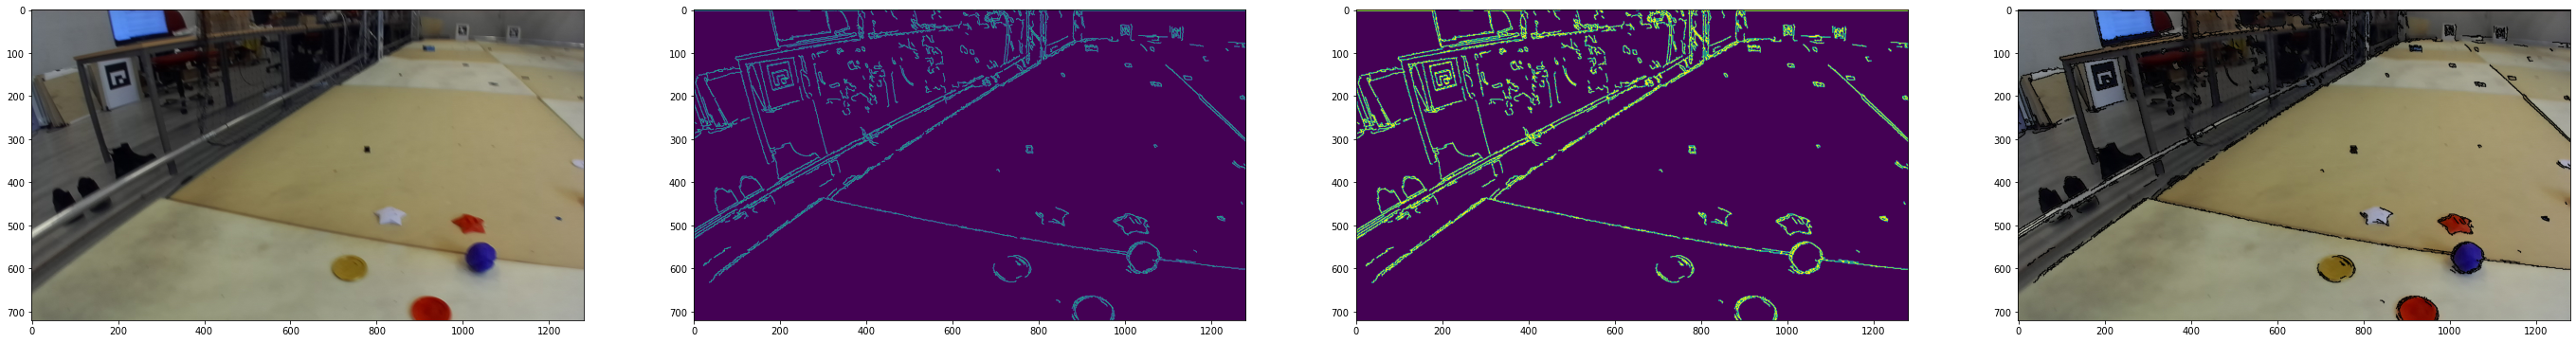

In [3]:
torch.cuda.empty_cache()
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

with open('AMR_dataset/filtered_dataset.csv', 'r') as read_obj: # https://thispointer.com/python-read-csv-into-a-list-of-lists-or-tuples-or-dictionaries-import-csv-to-list/
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    list_of_rows = np.array(list(csv_reader))
    #print('Shape of both:', list_of_rows.shape)
    file_list_images  = list_of_rows[1:,0]
    file_list_targets = list_of_rows[1:,1]
    #print('Path:', file_list_images)



dataset_images  = np.array([np.array(transform(np.array(PIL.Image.open(filename).convert('RGB')))) for filename in file_list_images])#.permute(0,3,1,2)
dataset_targets = np.array([np.array(PIL.Image.open(filename))[:,:,0] for filename in file_list_targets])#.permute(0,3,1,2)

# print("Images  shape:", dataset_images.shape)
# print("Targets shape:", dataset_targets.shape)
# dataset_images  = torch.tensor(dataset_images[:,1:-1,1:-1,:], device=device).permute(0,3,1,2) # [:,1:-1,1:-1,0:3] ignores edge pixels on all sides of the image, and 0:3 ignores the alpha value
dataset_images  = torch.tensor(dataset_images[:,:,1:-1,1:-1], device=device)#.permute(0,3,1,2) # [:,1:-1,1:-1,0:3] ignores edge pixels on all sides of the image, and 0:3 ignores the alpha value
dataset_targets = torch.tensor(dataset_targets[:,1:-1,1:-1], device=device)
# print("Images  shape:", dataset_images.shape)
# print("Targets shape:", dataset_targets.shape)
with torch.no_grad():

    # Pairing the images with the labels - train to test ratio of 5 to 1

    num_test = int(len(dataset_targets)/5) # will return 1/5 integer of the total sample size   
    # train_data = (images[num_test:len(targets)], targets[num_test:len(targets)])
    # test_data = (images[:num_test], targets[:num_test])
    train_data = [(img, t) for img, t in zip(dataset_images[num_test:len(dataset_targets)], dataset_targets[num_test:len(dataset_targets)])]
    test_data  = [(img, t) for img, t in zip(dataset_images[:num_test], dataset_targets[:num_test])]
    # train_data = train_data[:,:,:,:3]
    # test_data  = test_data[:,:,:,:1]

    # Dataloaders aplit the training and testing datasets into smaller batches
    # workers = 5
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)#,  num_workers=workers)#, pin_memory=True))
    test_loader  = DataLoader(dataset=test_data,  batch_size=batch_size, shuffle=False)#, num_workers=workers)#, pin_memory=True))

    # print('dataset_images: ', dataset_images.shape)
    # print('dataset_targets:', dataset_targets.shape)

    '''Plot from dataset - CPU'''
    # fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(24, 16))
    # ax[0][0].imshow(dataset_images[0])
    # ax[0][1].imshow(dataset_targets[0])
    # ax[1][0].imshow(dataset_images[83])
    # ax[1][1].imshow(dataset_targets[83])

    '''Plot from dataset - GPU'''
    # fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(24, 16))
    # ax[0][0].imshow(np.uint(dataset_images[0].to('cpu').permute(1,2,0)))
    # ax[0][1].imshow(dataset_targets[0].to('cpu'))
    # ax[1][0].imshow(dataset_images[83].to('cpu').permute(1,2,0)) #.permute(1,2,0)
    # ax[1][1].imshow(dataset_targets[83].to('cpu'))

    #'''Plot from dataloader''';
    # plot_img, plot_target = iter(train_loader).next()
    # plot_img = plot_img[0]
    # plot_target = plot_target[0]
    # fig, ax = plt.subplots(ncols=2, figsize=(24, 16))
    # ax[0].imshow(np.array(plot_img.to('cpu')).transpose(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
    # ax[1].imshow(np.array(plot_target.to('cpu')))

    #print('shape', dataset_images[0].shape)
    #image = np.uint8(dataset_images[0].to('cpu').numpy().transpose(1,2,0))
    image = np.array(PIL.Image.open(file_list_images[20]).convert('RGB'))
    print('shape after', image.shape)
    grey = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    line = cv.Canny(grey ,50,100,apertureSize = 3)
    kernel = np.ones((2,2), np.uint8)
    line_dilated = cv.dilate(line, kernel)
    outline_coords = np.where(line_dilated > 0)
    image_outlined = image.copy()
    image_outlined[outline_coords] = 2
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(48, 32))
    ax[0].imshow(image)
    ax[1].imshow(line)
    ax[2].imshow(line_dilated) # .convert('RGB')
    ax[3].imshow(image_outlined)

(718, 1278, 3)


(array([[388.,   0.,   0., ...,   0.,   0., 330.],
        [391.,   0.,   0., ...,   0.,   0., 327.],
        [398.,   0.,   0., ...,   0.,   0., 320.],
        ...,
        [718.,   0.,   0., ...,   0.,   0.,   0.],
        [715.,   0.,   0., ...,   0.,   0.,   3.],
        [716.,   0.,   0., ...,   0.,   0.,   2.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 1278 BarContainer objects>)

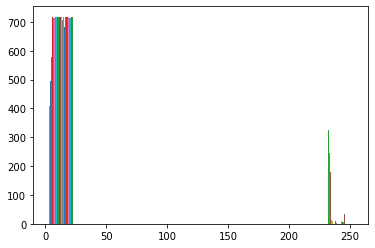

In [32]:
print(image.shape)
plt.hist(image[:,:,0])

(array([[  0.,   0.,  12., ..., 153., 184.,   1.],
        [ 10.,   6.,  77., ..., 117., 140.,   0.],
        [  1.,   9.,  36., ...,  96., 134.,   0.],
        ...,
        [ 80.,   3.,   8., ...,   0.,   0.,   0.],
        [ 79.,   5.,   5., ...,   0.,   0.,   0.],
        [ 77.,   5.,   9., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 718 BarContainer objects>)

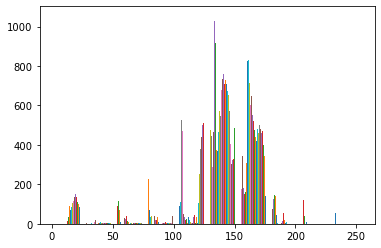

In [ ]:
plt.hist(dataset_images[0,0,:,:].to('cpu'))

(array([[  0.,   0.,  12., ..., 153., 184.,   1.],
        [ 10.,   6.,  77., ..., 117., 140.,   0.],
        [  1.,   9.,  36., ...,  96., 134.,   0.],
        ...,
        [ 80.,   3.,   8., ...,   0.,   0.,   0.],
        [ 79.,   5.,   5., ...,   0.,   0.,   0.],
        [ 77.,   6.,   8., ...,   0.,   0.,   0.]]),
 array([-2.117904  , -1.6812227 , -1.2445415 , -0.80786026, -0.37117904,
         0.06550217,  0.5021834 ,  0.9388646 ,  1.3755459 ,  1.812227  ,
         2.2489083 ], dtype=float32),
 <a list of 718 BarContainer objects>)

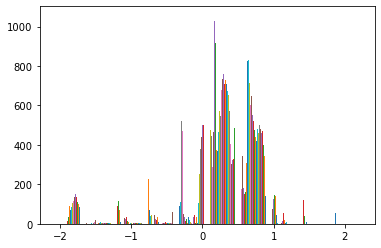

In [40]:
plt.hist(dataset_images[0,0,:,:].to('cpu'))

In [4]:
# Find all class RGB values in an image
# img_target = dataset_images[0] # opencv uses GBR
# img_target_RGB = img_target
# print(img_target.shape)
# # np.where(np.all(img_target == np.array()))
# h, w = img_target_RGB.shape[:2]
# colors=[]
# for x in range(w):
#     for y in range(h):
#         pixel = img_target[y,x]
#         if str(pixel) not in colors:
#             colors.append(str(pixel))

# print(colors)

print(len(test_data))
print(len(train_data))

21
85


In [5]:
'''Loading saved model''';
# model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=num_classes, aux_loss=False, pretrained_backbone=True).to(device)
# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

# loaded_checkpoint = torch.load("UPDATE PATH")

# # for param in model.parameters():    # Freezing the startign layers
# #     # param.requires_grad = False
# #     param.requires_grad = False

# model.load_state_dict(loaded_checkpoint["model_state"])
# optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])
# epoch = loaded_checkpoint["epoch"]
# criterion = nn.CrossEntropyLoss()

In [5]:
'''Loading new model''';
model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=num_classes, aux_loss=False, pretrained_backbone=True).to(device)

# Finetuning
# for param in model.parameters():    # Freezing/unfreezing the starting layers
#     # param.requires_grad = False
#     param.requires_grad = False

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-8)
criterion = nn.CrossEntropyLoss()


Starting training
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])


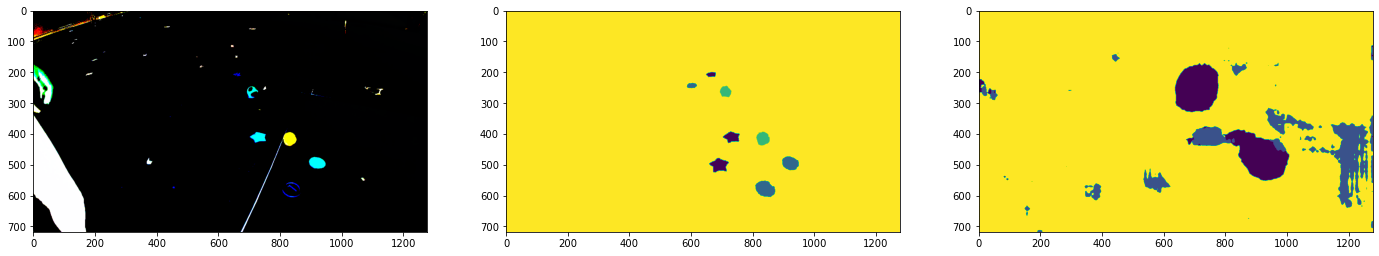

Epoch 1/50, step 5/43, loss = 1.31457
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])
Images:  torch.Size([2, 3, 718, 1278])
Targets: torch.Size([2, 718, 1278])
Outputs: torch.Size([2, 5, 718, 1278])


KeyboardInterrupt: 

<Figure size 1728x1152 with 0 Axes>

In [6]:
'''Training'''
# Tensorboard
#writer.add_graph(model.cpu(), val_dataset[0][0])
#writer.close()

# Doing the training now

n_total_steps = len(train_loader)

steps_until_print = batch_size

# stop_training = False
# def signal_handler(sig, frame):
#     print('\nDetected Ctrl+C, stopping training')
#     stop_training = True
#     print('Saving model')
# signal.signal(signal.SIGINT, signal_handler)

model.train()
print('Starting training')
for epoch in range(num_epochs):
    #if stop_training: break

    # Check for stop - read file for boolean to stopping safely
    with open("train.json") as train_json:
        train_dict = json.load(train_json)
        if train_dict["train"] == "False": break

    testing_batches = iter(test_loader) # Every epoch tests the whole dataset once

    for i, (images, targets) in enumerate(train_loader):
            # Check for stop - read file for boolean to stopping safely
        with open("train.json") as train_json:
            train_dict = json.load(train_json)
            if train_dict["train"] == "False": break

        images = images.to(device, torch.float32)
        targets = targets.to(device)
        # print('images  shape:', images.shape)
        # print('targets shape:', targets.shape)

        # Forward pass
        outputs = model(images)['out']
        # print("outputs shape:", outputs.shape)

        # print('Images: ', images.shape)
        # print('Targets:', targets.shape)
        # print('Outputs:', outputs.shape)

        loss = criterion(outputs, targets.long())

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights - seen at model.parameters()

        with torch.no_grad():

            # Logging the train accuracy
            pred = torch.argmax(outputs, dim=1)     # Evaluate along the 1st dimension
            batch_pixel_accuracy = (pred == targets).sum().item()/(batch_size*pred.shape[1]*pred.shape[2])
            writer.add_scalar('Accuracy/training', batch_pixel_accuracy, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # Logging the train loss
            writer.add_scalar('Loss/training', loss.item()/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

            # For every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_targets = testing_batches.next()
                
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)#.squeeze(1)

                model.eval()
                test_outputs = model(test_images.float())['out']
                model.train()
                    
                test_pred = torch.argmax(test_outputs, dim=1)

                '''Plot test results'''
                fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
                ax[0].imshow(test_images[0].to('cpu', torch.uint8).permute(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
                ax[1].imshow(test_targets[0].to('cpu'))
                ax[2].imshow(test_pred[0].to('cpu').detach())
                plt.pause(0.01)
                '''                     '''

                # print('test_images  shape:', test_images.shape)
                # print('test_targets shape:', test_targets.shape)
                # print('test_outputs shape:', test_outputs.shape)
                # print('test_pred    shape:', test_pred.shape)

                # writer.add_images('test/images',      test_images                  , epoch * n_total_steps + i)
                # writer.add_images('test/targets',     test_targets.unsqueeze(dim=1), epoch * n_total_steps + i)
                # writer.add_images('test/predictions', test_pred.unsqueeze(dim=1)   , epoch * n_total_steps + i)

                # Logging the test accuracy
                test_batch_pixel_accuracy = (test_pred == test_targets).sum().item()/(batch_size*test_pred.shape[1]*test_pred.shape[2])
                #print('Test batch pixel accuracy', test_batch_pixel_accuracy)
                writer.add_scalar('Accuracy/testing', test_batch_pixel_accuracy, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                # Logging the test loss
                test_loss = criterion(test_outputs, test_targets.long())
                writer.add_scalar('Loss/testing', test_loss.item()/len(test_targets), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

                #writer.add_scalars("Accuracy", {"train": batch_pixel_accuracy, "test": test_batch_pixel_accuracy}, epoch * n_total_steps + i)

                print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
                

    #print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')

print("Training is done")
# Void = 0
# Star = 1
# Coin = 2
# Mushroom = 3
# Background = 4

In [8]:
'''Saving the model''';
# checkpoint = {
#     "epoch": epoch,
#     "model_state": model.state_dict(),
#     "optimiser_state": optimiser.state_dict()
# }
# torch.save(checkpoint, "checkpoint_resnet50_50epoch_0.989p_AMR.pth")

In [ ]:
'''Plotting''';
# with torch.no_grad():
#     iterator = iter(test_loader)
#     images, targets = next(iterator)
#     images = images.to(device)

#     model.eval().to(device)
#     output = model(images.to(device))['out']
#     pred = torch.argmax(output, dim=1)

#     images = images.to('cpu')
#     targets = targets.to('cpu')
#     output = output.to('cpu')
#     pred = pred.to('cpu')
#     print('image: ', images.shape)
#     print('target:', targets.shape)
#     print('output:', output.shape)
#     print('pred:  ', pred.shape)
#     fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
#     ax[0].imshow(images[1].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
#     ax[1].imshow(targets[1].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
#     ax[2].imshow(pred[1].squeeze())

print('Hi')

In [6]:
#file_list_depth = sorted(glob.glob('AirSimDataset4/img_rgbd_camera_1_*.png'))
#dataset_images  = np.array([np.array(Image.open(filename)) for filename in file_list_images])


array([[5.2695312, 5.2695312, 5.2695312, ..., 7.4101562, 7.3984375,
        7.390625 ],
       [5.2929688, 5.2929688, 5.2929688, ..., 7.4257812, 7.4179688,
        7.4140625],
       [5.9453125, 5.9453125, 5.3320312, ..., 7.4492188, 7.4453125,
        7.4453125],
       ...,
       [1.1044922, 1.1044922, 1.1044922, ..., 1.0625   , 1.0625   ,
        1.0625   ],
       [1.0996094, 1.0996094, 1.0996094, ..., 1.0585938, 1.0585938,
        1.0585938],
       [1.0947266, 1.0947266, 1.0947266, ..., 1.0537109, 1.0537109,
        1.0537109]], dtype=float32)

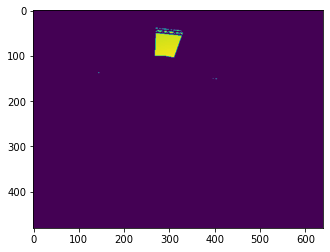

In [7]:
images_and_depths = zip(file_list_images, file_list_depths)


In [8]:
images.shape

NameError: name 'images' is not defined

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([1.20996094e+00, 1.71468896e+03, 3.42816797e+03, 5.14164697e+03,
        6.85512598e+03, 8.56860547e+03, 1.02820840e+04, 1.19955625e+04,
        1.37090420e+04, 1.54225215e+04, 1.71360000e+04], dtype=float32),
 <a list of 640 BarContainer objects>)

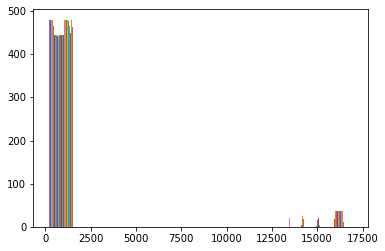

In [16]:
plt.hist(dataset_depths[70])